In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

random_number = 42
torch.manual_seed(random_number)
np.random.seed(random_number)

### Data

In [2]:
data = np.load('Datasets/NonLinear_data.npy', allow_pickle=True).item()
X = data['X']
y = data['labels']
X.shape, y.shape
X
y == 0
X[y == 0, 0]

array([ 0.00000000e+00,  9.60083739e-04,  1.04586376e-02,  8.79222065e-04,
        9.91726687e-03,  6.77282958e-03,  1.41908220e-02,  3.11579559e-02,
       -8.03243759e-03,  4.44744542e-02,  4.42749312e-02,  1.35659734e-02,
        4.51006429e-02,  8.18222344e-02,  1.02915603e-01,  1.09463907e-01,
        9.88552373e-02,  1.33913469e-01,  1.67286205e-01,  1.70560114e-01,
        1.40953043e-01,  1.28611110e-01,  1.42427503e-01,  1.90889800e-01,
        1.87648899e-01,  1.93996423e-01,  2.35108650e-01,  2.38113100e-01,
        2.06828734e-01,  2.45415985e-01,  2.55215494e-01,  2.80125835e-01,
        3.16878418e-01,  3.32309744e-01,  3.39400399e-01,  3.21515600e-01,
        3.62893868e-01,  3.72459579e-01,  3.44045539e-01,  3.93344162e-01,
        4.02414702e-01,  4.09482790e-01,  4.23463074e-01,  4.16583904e-01,
        4.39008393e-01,  4.43991826e-01,  4.21672418e-01,  4.65087655e-01,
        4.11768742e-01,  4.86187266e-01,  4.41729837e-01,  4.12337255e-01,
        4.84000848e-01,  

### Visualization

Text(0.5, 1.0, 'Scatter Plot of Non-linear Data Classification')

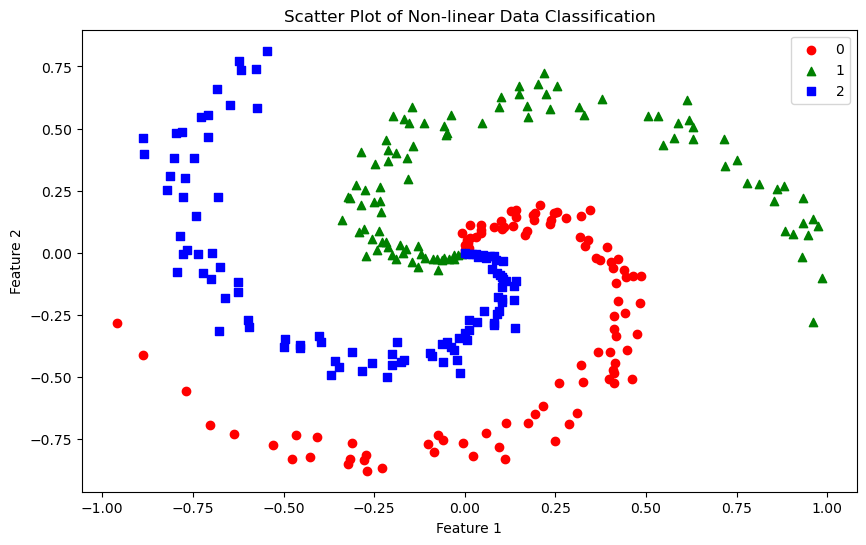

In [3]:
color = ['red', 'green', 'blue']
markers = ['o', '^', 's']

plt.figure(figsize=(10, 6))

for i, class_label in enumerate(np.unique(y)):
    plt.scatter(
        X[y == class_label, 0], 
        X[y == class_label, 1], 
        c=color[i], 
        marker=markers[i], 
        label=class_label)
plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Non-linear Data Classification')

### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3333333, random_state=42, shuffle=True, stratify=y_test)

X_val.shape[0], X_test.shape[0], X_train.shape[0], y_train.shape[0]

(60, 30, 210, 210)

### Normalization

In [5]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

X_val = scaler.transform(X_val)

In [6]:
# convert to tensor
X_train = torch.tensor(X_train, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

In [7]:
y_train.shape

torch.Size([210])

### Build DataLoader

In [8]:
batch_size = 32

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
val_data = CustomDataset(X_val, y_val)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


### Build MLP model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, output_size):
        super().__init__()
        
        layers = [
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU()
        ]

        for _ in range(hidden_layer - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_size, output_size))

        self.classifier = nn.Sequential(*layers)
    
    def forward(self, X):
        output = self.classifier(X)
        return output



### Training Session

In [25]:
lr = 0.01
epochs = 100
input_size = X_train.shape[1]
hidden_size = 5
hidden_layer = 3
output_size = len(np.unique(y))

In [26]:
train_lossess = []
val_lossess = []
accuracy_train = []
accuracy_val = []

In [ ]:
model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, hidden_layer=hidden_layer, output_size=output_size)

crition = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [28]:
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    y_train_label_pred = []
    y_train_label_true = []

    y_val_label_pred = []
    y_val_label_true = []

    # training session
    model.train()
    for X_train, y_train in train_loader:
        # reset optimizer to avoid accumalated gradients
        # from previous batch
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_train)

        # calculate loss
        loss = crition(y_pred, y_train)
        train_loss += loss.item()

        # concat
        y_train_label_true.extend(y_train.tolist())
        y_train_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        # calculate gradients of the loss with respect to the model parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

    train_loss /= len(train_loader)
    train_lossess.append(train_loss)

    accuracy_train.append(accuracy_score(y_train_label_true, y_train_label_pred))
    
    # validation session
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            # forward pass
            y_pred = model(X_val)

            # calculate loss
            loss = crition(y_pred, y_val)
            val_loss += loss.item()

            # concat
            y_val_label_true.extend(y_val.tolist())
            y_val_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        val_loss /= len(val_loader)
        val_lossess.append(val_loss)

        accuracy_val.append(accuracy_score(y_val_label_true, y_val_label_pred))

    
    


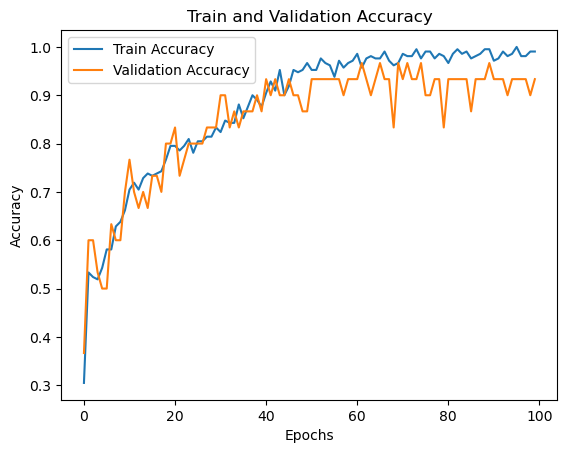

In [34]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

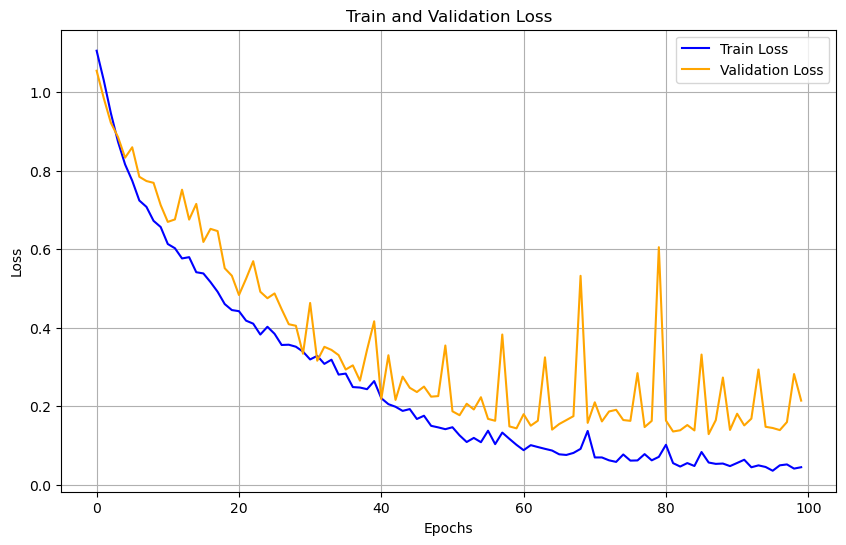

In [30]:
# Visualisation of the loss
plt.figure(figsize=(10, 6))
plt.plot(train_lossess, label='Train Loss', color='blue')
plt.plot(val_lossess, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.grid()
plt.legend()
plt.show()

### Testing Session

In [31]:
model.eval()
y_test_label_true = []
y_test_label_pred = []
val_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # forward pass
        y_pred = model(X_test)

        # calculate loss
        loss = crition(y_pred, y_test)
        val_loss += loss.item()

        # concat
        y_test_label_true.extend(y_val.tolist())
        y_test_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

    val_loss /= len(val_loader)
    val_lossess.append(val_loss)

    accuracy = accuracy_score(y_val_label_true, y_val_label_pred)

print(f'Test Loss: {val_loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.2144
Test Accuracy: 0.9333
